In [5]:
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import ElasticNet
from statsmodels.regression.linear_model import OLS
from sklearn import preprocessing
import math
from sklearn.ensemble import RandomForestRegressor as RDFR
from sklearn.ensemble import RandomForestClassifier as RDFC
from sklearn.linear_model import Ridge, RidgeCV, LassoCV,Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import seaborn.apionly as sns
%matplotlib inline

In [17]:
result= pd.read_csv('imdb_cluster_result.csv')

In [7]:
result.head()

,X,certificates_R,certificates_PG,art.direction_1,assistant.director_1,casting.director_1,cinematographer_1,costume.department_1,costume.designer_1,countries_1,...,Action,Documentary,Musical,History,Family,Fantasy,Sport,Biography,cluster_response,genres_comb
0,100,1,0,0.322495,0.042103,0.010279,0.046254,0.307966,0.028662,0.089642,...,0,0,0,0,0,0,0,0,5,"Horror, Thriller, Action"
1,10001,0,1,0.027673,0.093694,0.319431,0.165250,0.307966,0.172860,0.014232,...,0,0,0,1,0,0,0,0,4,"Romance, Comedy, Fantasy"
2,10002,1,0,0.212394,0.024906,0.006523,0.016308,0.012453,0.005535,0.089642,...,0,0,0,0,0,0,0,0,1,"Horror, Thriller, Drama"
3,10003,0,1,0.019767,0.024906,0.014133,0.025301,0.126112,0.007116,0.536766,...,1,0,0,0,0,0,0,0,1,"Horror, Thriller, Drama"
4,10004,1,0,0.104764,0.355406,0.017395,0.049812,0.126112,0.040028,0.536766,...,0,0,0,0,0,1,0,0,1,"Horror, Thriller, Drama"


In [13]:
result.shape

(10118, 58)

In [14]:
result.columns.values

array(['X', 'certificates_R', 'certificates_PG', 'art.direction_1',
       'assistant.director_1', 'casting.director_1', 'cinematographer_1',
       'costume.department_1', 'costume.designer_1', 'countries_1',
       'director_1', 'distributors_1', 'editor_1', 'languages_1',
       'make.up_1', 'miscellaneous.companies_1', 'miscellaneous.crew_1',
       'original.music_1', 'producer_1', 'production.companies_1',
       'production.manager_1', 'set.decoration_1', 'sound.crew_1',
       'stunt.performer_1', 'visual.effects_1', 'writer_1', 'cast_1',
       'cast_2', 'cast_3', 'cast_4', 'runtimes_avg', 'rating', 'Sci.Fi',
       'Crime', 'Romance', 'Animation', 'Music', 'Adult', 'Comedy', 'War',
       'Horror', 'Film.Noir', 'Western', 'Thriller', 'Adventure',
       'Mystery', 'Short', 'Drama', 'Action', 'Documentary', 'Musical',
       'History', 'Family', 'Fantasy', 'Sport', 'Biography',
       'cluster_response', 'genres_comb'], dtype=object)

In [16]:
result['cluster_response'].describe()

count    10118.000000
mean         2.816466
std          1.678704
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max          5.000000
Name: cluster_response, dtype: float64

In [8]:
X_train=result.ix[:,2:32].values
y=result['cluster_response'].values

In [29]:
X_train.shape

(10118, 30)

In [30]:
y.shape

(10118,)

# Feature Selection

1. Ridge Regression
2. LASSO Regression
3. Random Forest

### 1. Ridge Regression

In [31]:
from sklearn.linear_model import Ridge, RidgeCV, LassoCV,Lasso
from sklearn.model_selection import cross_val_score
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

In [32]:
num_lambdas = 100
lambdas= np.linspace(-7,7, num_lambdas)

cv_ridge = [rmse_cv(Ridge(alpha = 10**i)).mean() 
            for i in lambdas]

Ridge Regression: min RMSE on training set 1.09842217792


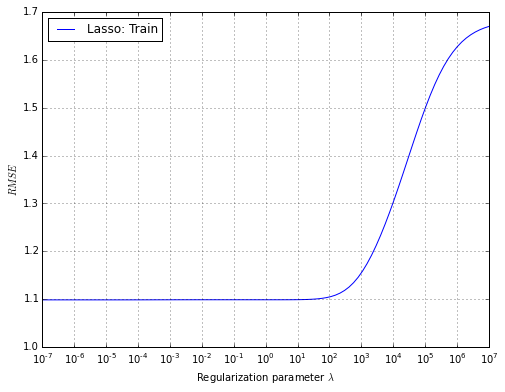

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.semilogx(10.0**lambdas, (cv_ridge), c='b', label='Lasso: Train')

ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel(r'$RMSE$')

ax.grid()
ax.legend(loc = 'best')

print 'Ridge Regression: min RMSE on training set', min(cv_ridge)

### Resule of best ridge model

In [37]:
min_value = min(cv_ridge)
min_index = cv_ridge.index(min_value)

In [38]:
print "Lambda for min RMSE:", lambdas[min_index]

Lambda for min RMSE: -5.0202020202


In [39]:
best_ridge=Ridge(alpha = 10**(lambdas[min_index])).fit(X_train, y)

In [40]:
print "Min RMSE for Ridge Model:", rmse_cv(best_ridge).mean()

Min RMSE for Ridge Model: 1.09843593824


In [45]:
coef = pd.Series(best_ridge.coef_, index = result.columns[2:32])
newcoef=pd.DataFrame(coef)
newcoef_sorted = newcoef.sort_values(by=[0], ascending=[False])
imp_coef = pd.concat([newcoef_sorted.head(10),
                     newcoef_sorted.tail(10)])

In [46]:
color_selection = ['lightslategray','darkseagreen','palevioletred','gold','coral','skyblue','darkseagreen','palevioletred','gold','coral','skyblue','darkseagreen','palevioletred','gold','tan','lightslategray','darkseagreen','palevioletred','gold','coral']

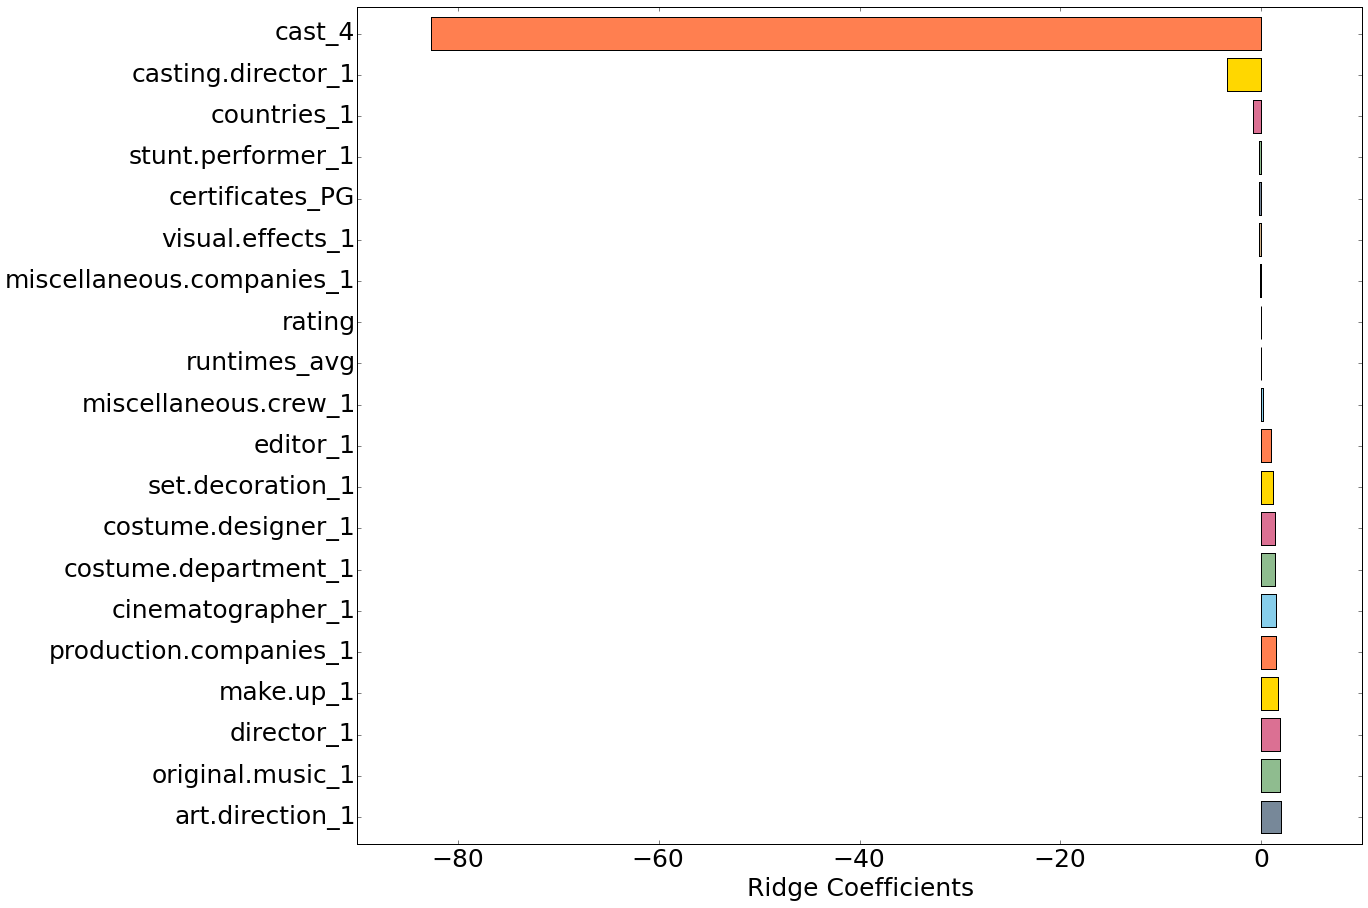

In [47]:
matplotlib.rcParams['figure.figsize'] = (18.0, 15.0)
imp_coef.plot(kind = "barh", color=color_selection,width = 0.8, legend=None, fontsize = 25)
plt.xlabel('Ridge Coefficients', fontsize = 25)

plt.show()

### 2. LASSO

In [48]:
num_lambdas = 100
lambdas= np.linspace(-7,7, num_lambdas)

cv_lasso = [rmse_cv(Lasso(alpha = 10**i)).mean() 
            for i in lambdas]

Lasso Regression: min RMSE on training set 1.0984371818


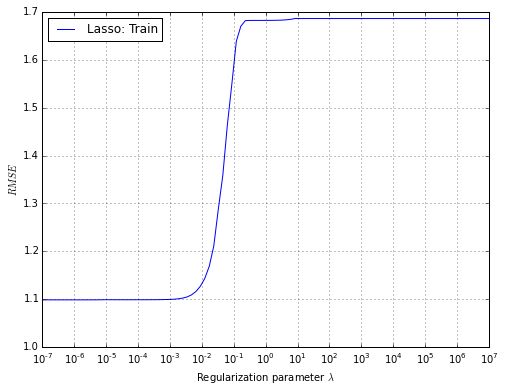

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.semilogx(10.0**lambdas, (cv_lasso), c='b', label='Lasso: Train')

ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel(r'$RMSE$')

ax.grid()
ax.legend(loc = 'best')

print 'Lasso Regression: min RMSE on training set', min(cv_lasso)

In [50]:
min_value = min(cv_lasso)
min_index = cv_lasso.index(min_value)

In [51]:
best_lasso=Lasso(alpha = 10**(lambdas[min_index])).fit(X_train, y)

In [52]:
print "Lambda for min RMSE:", lambdas[min_index]

Lambda for min RMSE: -7.0


In [53]:
print "Min RMSE for Ridge Model:", rmse_cv(best_lasso).mean()

Min RMSE for Ridge Model: 1.0984371818


In [54]:
coef = pd.Series(best_lasso.coef_, index = result.columns[2:32])

In [55]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 30 variables and eliminated the other 0 variables


In [56]:
newcoef=coef[coef != 0]
newcoef=pd.DataFrame(newcoef)
newcoef_sorted = newcoef.sort_values(by=[0], ascending=[False])
imp_coef = pd.concat([newcoef_sorted.head(10),
                     newcoef_sorted.tail(10)])

In [57]:
color_selection = ['lightslategray','darkseagreen','palevioletred','gold','coral','skyblue','darkseagreen','palevioletred','gold','coral','skyblue','darkseagreen','palevioletred','gold','tan','lightslategray','darkseagreen','palevioletred','gold','coral']

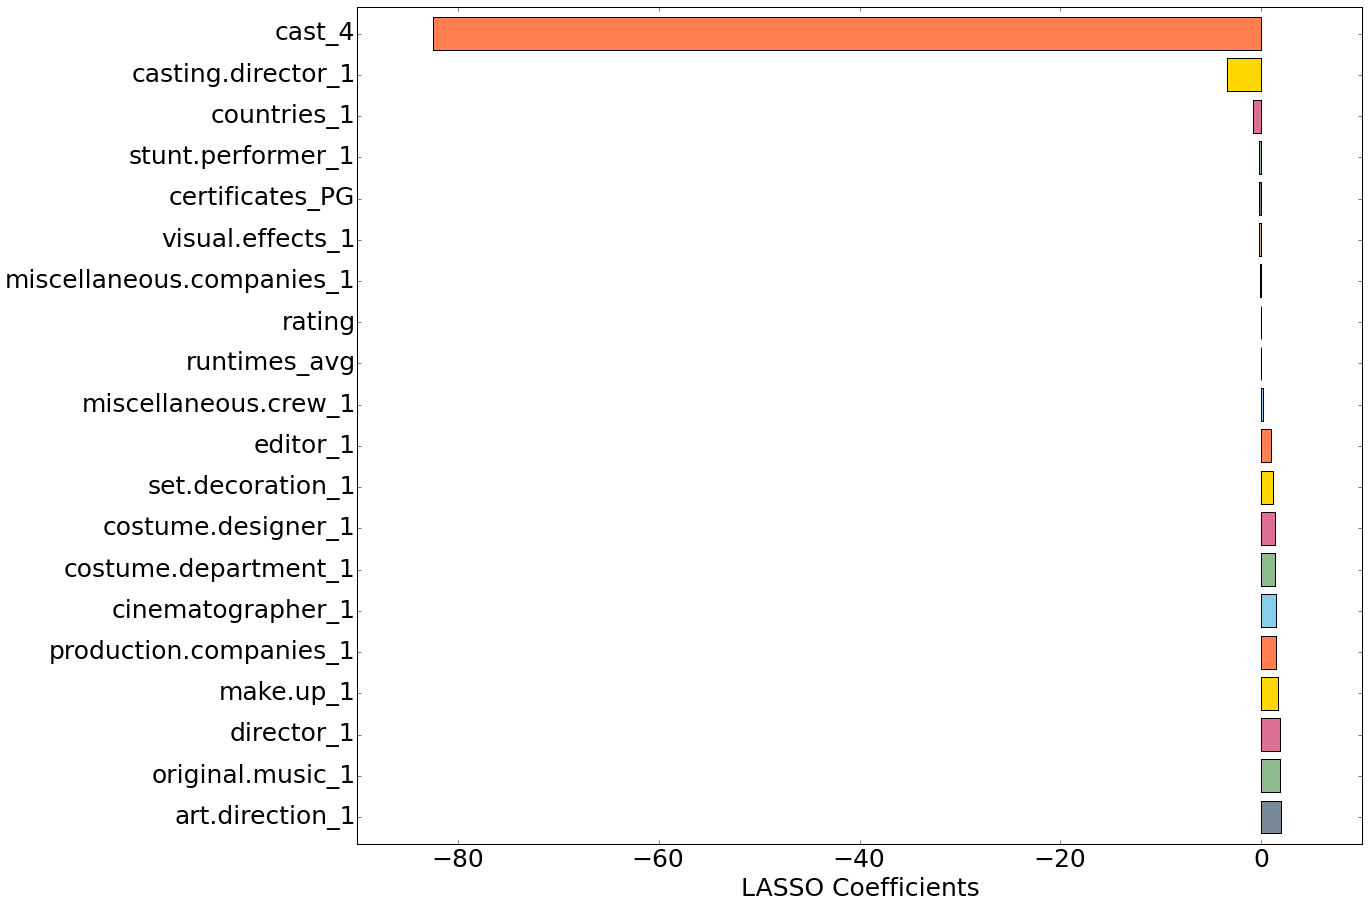

In [58]:
matplotlib.rcParams['figure.figsize'] = (18.0, 15.0)
imp_coef.plot(kind = "barh", color=color_selection,width = 0.8, legend=None, fontsize = 25)
plt.xlabel('LASSO Coefficients', fontsize = 25)
# plt.title("Coefficients in the Lasso Model")

plt.show()

### 3. Random Forest

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

/Users/aixu/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/aixu/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# A generic function to do CV
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)

    best = gs.best_estimator_
    results=gs.grid_scores_
    return best, results

In [9]:
clfForest = RandomForestClassifier(oob_score=True, max_features='auto')
clf=clfForest.fit(X_train, y)

/Users/aixu/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/aixu/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


#### Use cross-validatioon (5-fold) to find best depth and number of estimators

In [10]:
n=range(10,100,10)
m=range(1,20,5)
parameters = {"max_depth": m, 'n_estimators': n}
clf,result0 = cv_optimize(clfForest, parameters, X_train, y, n_jobs=10, n_folds=5, score_func=None);
print clf.max_depth, clf.n_estimators

16 90


In [11]:
clfForest = RandomForestClassifier(n_estimators=60, oob_score=True, max_features='auto', max_depth=5)

clf=clfForest.fit(X_train, y)
clf.score(X_train,y)

0.85481320419055151

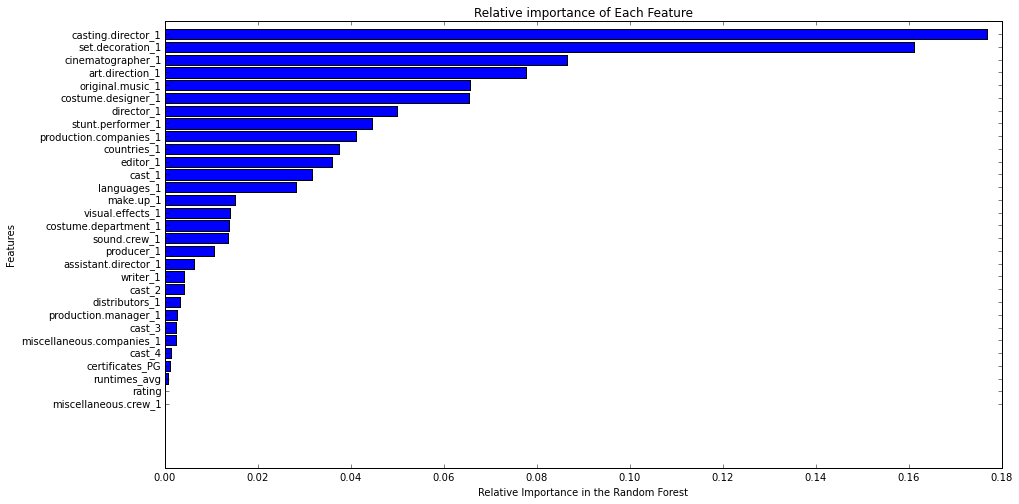

In [18]:
plt.figure(figsize=(15,8))
importance_list = clfForest.feature_importances_
name_list = result.columns[2:32]
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()